## Studying the variation of  $B$ vs $\rho$  using Bayesian Fitting

Date: 23 September 2021;
Modified: November 12 2021

Author: Sayantan Auddy

Objectives:
To determine the slopes $\kappa_1$ and $\kappa_2$ and the transitioning density
from the flat $B \propto \rho^{\kappa_1}$ to the power-law $B \propto \rho^{\kappa_2}$ part of the distribution 

For simplicity we define a piecewise function with four parameters


In [1]:
## Importing the necessary modules ##

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from numba import vectorize
import glob

## Import modules for the statistical part
from scipy import stats
import tqdm
import time

## For ploting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rc('text', usetex=True)
# plt.style.use('classic')

## Import the customized function to read the simulation data
import read_data as rd

## Reading the data 

In [2]:
save_path_plots = './plots/'

path = './data_Updated/'
fit_model = 'dat'

list_of_files_B = glob.glob(path+"BB"+'*'+fit_model)
list_of_files_rho = glob.glob(path+"rho"+'*'+fit_model)


list_B = np.sort(list_of_files_B)
list_rho=  np.sort(list_of_files_rho)
print(list_B)
# print(list_rho)

['./data_Updated/BB_B10_V40.dat' './data_Updated/BB_B16_V20.dat'
 './data_Updated/BB_B16_V30.dat' './data_Updated/BB_B25_V20.dat'
 './data_Updated/BB_B25_V30.dat']


## Plotting the data

./data_Updated/BB_B10_V40.dat ./data_Updated/rho_B10_V40.dat


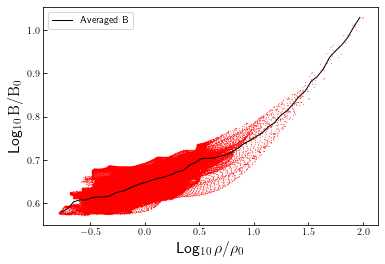

In [3]:
sel = 0
Magnetic_field,density,Column_density,bin_means,bincenter = rd.magetic_field_VS_density(list_B[sel],list_rho[sel],option="Density",cutoff=0)

x = density
y = Magnetic_field
plt.scatter(x, y,color='r',s=0.03)
plt.plot(bincenter,bin_means,'-',color='k',linewidth='1',label="Averaged B")
plt.ylabel(r"Log$_{10}\, \rm B/B_{0} $",fontsize=16)
plt.xlabel(r"Log$_{10} \,\rho/\rho_{0}$",fontsize=16)
plt.legend(loc="best")
plt.show()

In [4]:
from scipy.optimize import curve_fit
# @vectorize
def piecewise_linear_Bayesian(params):
    x0, y0, k1, k2,std_dev = params
    
    B = np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

#     std_dev = 1
    LL = np.sum(stats.norm.logpdf(B,y,scale=std_dev))
    
    return LL


In [5]:
def log_prior(params):
    x0, y0, k1, k2,std_dev = params
    
    #if 0 <= mu <= 20 and 0 <= gamma <= 90 and 10 <= lambda0 <= 50 and 20 <= lambda1 <= 100 and 0 <= std_dev <=1:
#     if 0.95 <= x0 <= 2 and 0 <= y0 <= 1 and 0 <= k1 <=1 and 0 <= k2 <=1 and 0<= std_dev <=1:
    if 0.50 <= x0 <= 2 and 0 <= y0 <= 1 and 0 <= k1 <=1 and 0 <= k2 <=1 and 0<= std_dev <=1:
        return 0.0       # prior = 1 -->  log(1) = 0
    else:
        return -np.inf   # prior = 0 -->  log(0) = - infinity

In [6]:
# @vectorize
def log_posterior(params):
    """
    Posterior = Likelihood x Prior x Constant
    """
    lprior = log_prior(params)
    if np.isfinite(lprior):
        #return lprior + log_likelihood(params)
        return lprior + piecewise_linear_Bayesian(params)
    else:
        return -np.inf

In [7]:
# MCMC Setup
ndim = 5
nwalkers = 8 * ndim
positions = np.zeros((nwalkers,ndim))
positions[:,0] = 1.0 + np.random.rand(nwalkers) # 0 < x0 < 2.0
positions[:,1] = np.random.rand(nwalkers) # 0 < y0 < 90
positions[:,2] = np.random.rand(nwalkers) # 0 < k1 < 10
positions[:,3] = np.random.rand(nwalkers) # 0 < k2 < 10
positions[:,4] = np.random.rand(nwalkers) # 0 < std_dev < 1

# positions

In [8]:
## Checking the number of available cores in the system
from multiprocess import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


In [9]:
# from multiprocessing import Pool
import multiprocess as mp

with mp.Pool(6) as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,log_posterior,pool=pool)
    start = time.time()
    state  = sampler.run_mcmc(positions,1000,progress=True)
    sampler.reset()
    nsteps = 40000
    sampler.run_mcmc(state,nsteps,progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#     print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [3:49:29<00:00,  2.90it/s]

Multiprocessing took 14098.0 seconds


In [10]:
accept = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: %0.3f" % accept)

Mean acceptance fraction: 0.549


In [11]:
corr_time = sampler.get_autocorr_time()
for i in range(ndim):
  print("Auto-correlation time for parameter %d: %0.3f steps" % (i,corr_time[i]))
  print("nsteps / corr_time = %f\n" % (nsteps/corr_time[i]) )

Auto-correlation time for parameter 0: 57.576 steps
nsteps / corr_time = 694.736563

Auto-correlation time for parameter 1: 57.793 steps
nsteps / corr_time = 692.120239

Auto-correlation time for parameter 2: 57.209 steps
nsteps / corr_time = 699.192061

Auto-correlation time for parameter 3: 59.457 steps
nsteps / corr_time = 672.749491

Auto-correlation time for parameter 4: 59.006 steps
nsteps / corr_time = 677.900184



In [12]:
# corr_time =20
nthin = int(np.mean(corr_time)/2)

In [13]:
samples = sampler.get_chain(thin=int(np.mean(corr_time)/2), flat=True)
filename = list_B[sel].split('/')[2]
# print(sim_name)
sim_name = filename[4:6]+filename[8:10]
np.save('sample_'+str(sim_name)+'.npy', samples)    # .npy extension is added if not given
# d = np.load('test3.npy')

In [14]:
samples_mean = sampler.get_chain(thin=nthin, flat=True)
plot_data = np.column_stack([samples_mean[:,0], samples_mean[:,1],samples_mean[:,2],samples_mean[:,3]])
popt = []
for i in range(0,4):
    popt.append(samples_mean[:,i].mean())
    print(samples_mean[:,i].mean())
    print(samples_mean[:,i].std())

0.8962402508531311
0.012672665991279744
0.7248438883828099
0.0011382383517984814
0.08614294792643144
0.00016554949383077106
0.24009080504690153
0.005374850810056959


In [15]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

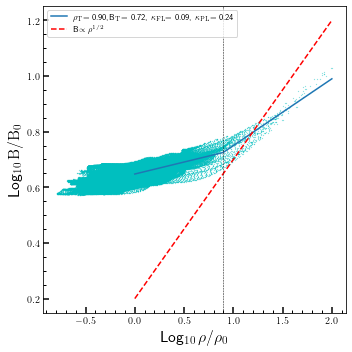

In [16]:
plt.figure(figsize = (5,5))
plt.scatter(x, y,color='c',s=0.03)

x_plot = np.linspace(0, 2, 100)
y1  = .5*x_plot +.2
y2 = (2/3)*x_plot 
plt.plot(x_plot, piecewise_linear(x_plot,*popt)
         ,label=r'$\rho_{\rm T}$=%5.2f,B$_{\rm T}$=%5.2f, $\kappa_{\rm FL}$=%5.2f, $\kappa_{\rm PL}$=%5.2f' % tuple(popt))
plt.plot(x_plot,y1,'r--',label=r"B$\propto\rho^{1/2}$")
plt.axvline(x=popt[0],linestyle='--',linewidth=0.5, color='k')
plt.ylabel(r"Log$_{10}\, \rm B/B_{0} $",fontsize=16)
plt.xlabel(r"Log$_{10} \,\rho/\rho_{0}$",fontsize=16)
plt.legend(loc=2, fontsize=8)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5)
plt.tick_params(which='minor', length=3, width=1, direction='in')
plt.tight_layout()
plt.savefig("B_rho.jpg",format='jpg',dpi=300)
plt.show()



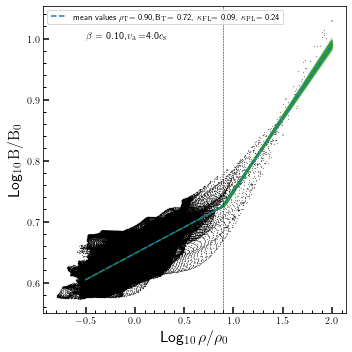

In [17]:
plt.figure(figsize = (5,5))
inds = np.random.randint(len(samples), size=1000)

np.save('sample_'+str(sim_name)+'.npy', samples)    # .npy extension is added if not given 
x_plot = np.linspace(-0.5, 2, 100)
for ind in inds[400:]:
    sample = samples[ind]
    plt.plot(x_plot, piecewise_linear(x_plot,*sample[:4]),"C2", alpha=0.02)
plt.scatter(x, y,color='k',s=0.03)
plt.plot(x_plot, piecewise_linear(x_plot,*popt),'--'
         ,label=r'mean values $\rho_{\rm T}$=%5.2f,B$_{\rm T}$=%5.2f, $\kappa_{\rm FL}$=%5.2f, $\kappa_{\rm PL}$=%5.2f' % tuple(popt))
plt.text(-.5,1,r' $\beta=$ '+str('0.'+filename[4:6])+r',$v_{\rm a} = $'+str(filename[8]+'.'+filename[9])+r'$c_{\rm s}$')
plt.axvline(x=popt[0],linestyle='--',linewidth=0.5, color='k')
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(loc="best",fontsize=8)
plt.ylabel(r"Log$_{10}\, \rm B/B_{0} $",fontsize=16)
plt.xlabel(r"Log$_{10} \,\rho/\rho_{0}$",fontsize=16)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5)
plt.tick_params(which='minor', length=3, width=1, direction='in')
plt.tight_layout()
# plt.savefig(save_path_plots2 +str(filename[4:6]+filename[8]+filename[9])+"fit.jpg",format='jpg',dpi=300)
plt.show()

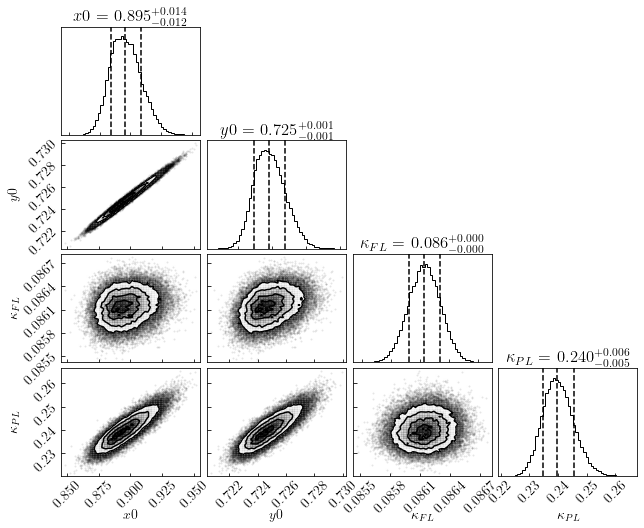

In [18]:
import corner
# range=[(0,2.0),(.5,.8),(0.03,0.12),(0.05,1.0)],
# labels = [r"$x0$", r"$y0$", r"$\kappa_{FL}$", r"$\kappa_{PL}$", r"$\kappa_{PL}$"]
labels = [r"$x0$", r"$y0$", r"$\kappa_{FL}$", r"$\kappa_{PL}$"]

plt.rc("font",size=14)

fig = plt.figure(2,figsize=(10,8))
fig.clf()
corner.corner(samples[:,:4],fig=fig,labels=labels,bins=50,
                quantiles=[0.16,0.5,0.84],show_titles=True,
                title_fmt=".3f")
fig.subplots_adjust(left=0.16,right=0.96,bottom=0.16,top=0.94)
# fig.show()

In [19]:
# samples[:,:4]